<a href="https://colab.research.google.com/github/avarlotta/time-series-forecasting/blob/main/forecasting_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-cloud-bigquery

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
from google.cloud import bigquery
client = bigquery.Client(project='prism-insights')

In [5]:
query = '''WITH sales_per_month AS (SELECT EXTRACT(YEAR FROM event_date) AS year,
                  EXTRACT(MONTH FROM event_date) AS month,
                  COUNT(event_name) AS Num_Sales
           FROM `prism-insights.prism_insights_dev.stg_funnel_events`
           WHERE event_name = 'purchase'
           GROUP BY year, month
           ORDER BY year, month)
           SELECT DATE(CAST(year AS INT), CAST(month AS INT), 1) AS DoM,
                  Num_Sales
           FROM sales_per_month
        '''
df = client.query(query).to_dataframe()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   DoM        28 non-null     dbdate
 1   Num_Sales  28 non-null     Int64 
dtypes: Int64(1), dbdate(1)
memory usage: 604.0 bytes


In [7]:
df.head()

,DoM,Num_Sales
0,2020-01-01,13240
1,2020-02-01,12079
2,2020-03-01,13359
3,2020-04-01,18047
4,2020-05-01,29450


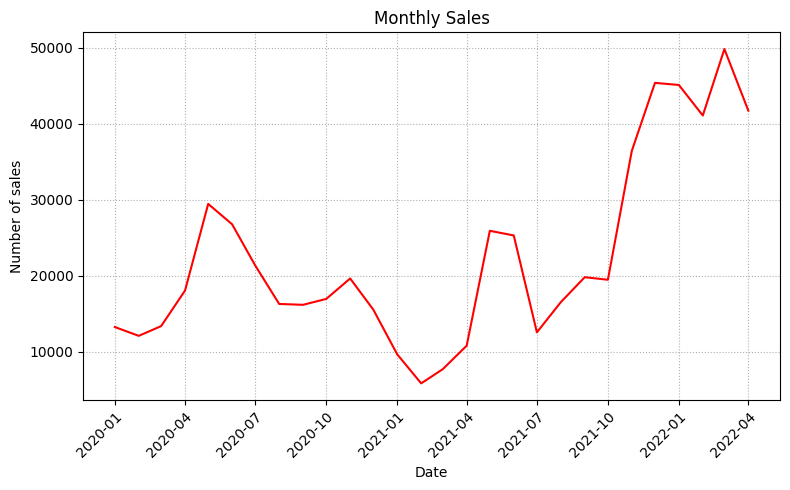

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(df.DoM, df.Num_Sales, color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Number of sales')
ax.set_title('Monthly Sales')
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor", rotation=45)
plt.grid(linestyle=':')
plt.tight_layout();

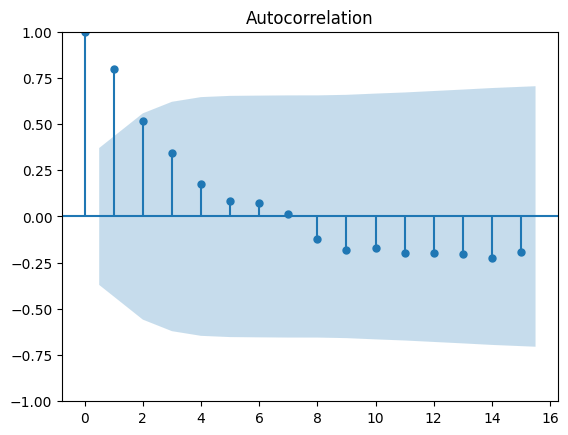

In [9]:
_ = plot_acf(df.Num_Sales)

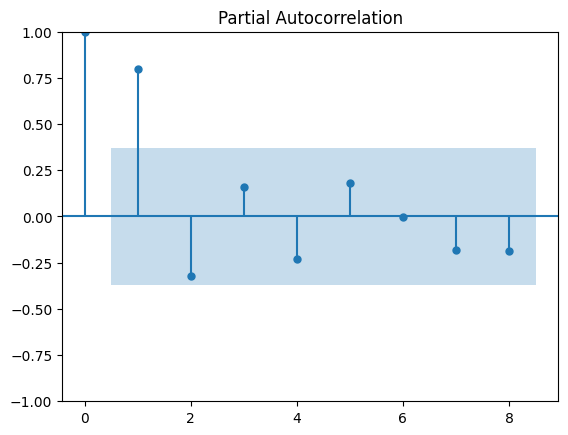

In [10]:
_ = plot_pacf(df.Num_Sales, lags=8)

In [11]:
arima_model = ARIMA(df.Num_Sales.astype(int), order=(2, 1 ,1))
model_fit = arima_model.fit()
# forecasting the next 12 months
forecast = model_fit.forecast(steps=12)

In [12]:
forecast_df = pd.DataFrame(forecast.tolist(), index=pd.date_range(start='2022-04-01', freq='M', periods=12))
forecast_df = forecast_df.rename(columns={0: 'Num_Sales'})

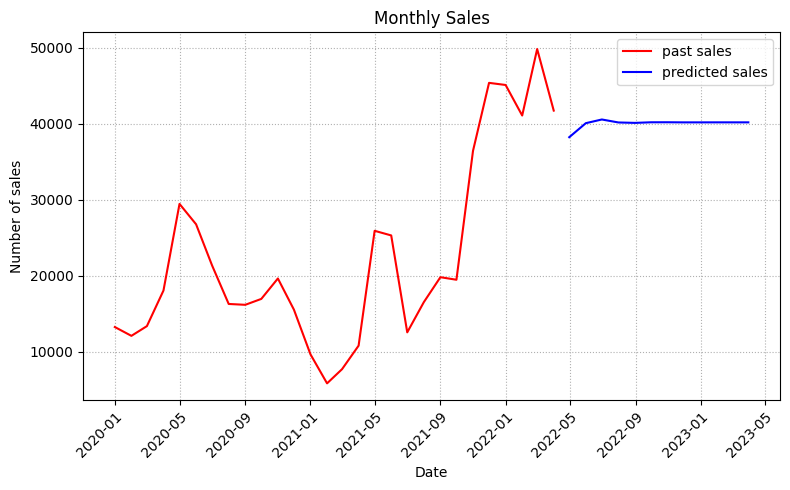

In [13]:
bfig, ax = plt.subplots(figsize=(8, 5))
ax.plot(df.DoM, df.Num_Sales,
        color='red', label='past sales')
ax.plot(forecast_df.index, forecast_df.Num_Sales,
        color='blue', label='predicted sales')
ax.set_xlabel('Date')
ax.set_ylabel('Number of sales')
ax.set_title('Monthly Sales')
plt.setp(ax.get_xticklabels(), ha="right",
         rotation_mode="anchor", rotation=45)
plt.grid(linestyle=':')
plt.legend()
plt.tight_layout();

In [14]:
results = adfuller(df.Num_Sales)
print(f'Test statistics: {round(results[0], 2)}\n'
      f'P-value: {round(results[1], 2)}\nNumber of lags used: {round(results[2], 4)}\n'
      f'Number of observations used: {round(results[3], 3)}\n'
      f'Critical values for the test statistic at the 1%, 5%, and 10% levels: {[round(list(results[4].values())[i], 3) for i in range(3)]}\n'
      f'The maximized information criterion if autolag is not None: {round(results[5], 2)}')

Test statistics: -1.1
P-value: 0.71
Number of lags used: 0
Number of observations used: 27
Critical values for the test statistic at the 1%, 5%, and 10% levels: [-3.7, -2.976, -2.628]
The maximized information criterion if autolag is not None: 375.27
